In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import warnings
warnings.filterwarnings("ignore")

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense,GlobalAveragePooling2D,Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import load_model
# Other libraries
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import cv2

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

# Image properties and directories
IMG_SHAPE = (200, 200)
TRAIN_DIR = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train'
VAL_DIR = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val'
TEST_DIR = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test'
BATCH_SIZE = 16

In [5]:
train_val_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_val_gen.flow_from_directory(
    TRAIN_DIR, 
    target_size=IMG_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    shuffle=True, 
    subset='training'
)

val_data = train_val_gen.flow_from_directory(
    VAL_DIR, 
    target_size=IMG_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    shuffle=False, 
    subset='validation'
)

test_data = test_gen.flow_from_directory(
    TEST_DIR, 
    target_size=IMG_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    shuffle=False
)

Found 5061 images belonging to 4 classes.
Found 6 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [6]:
class_labels = list(train_data.class_indices.keys())
print(f"Detected Classes: {class_labels}")

Detected Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


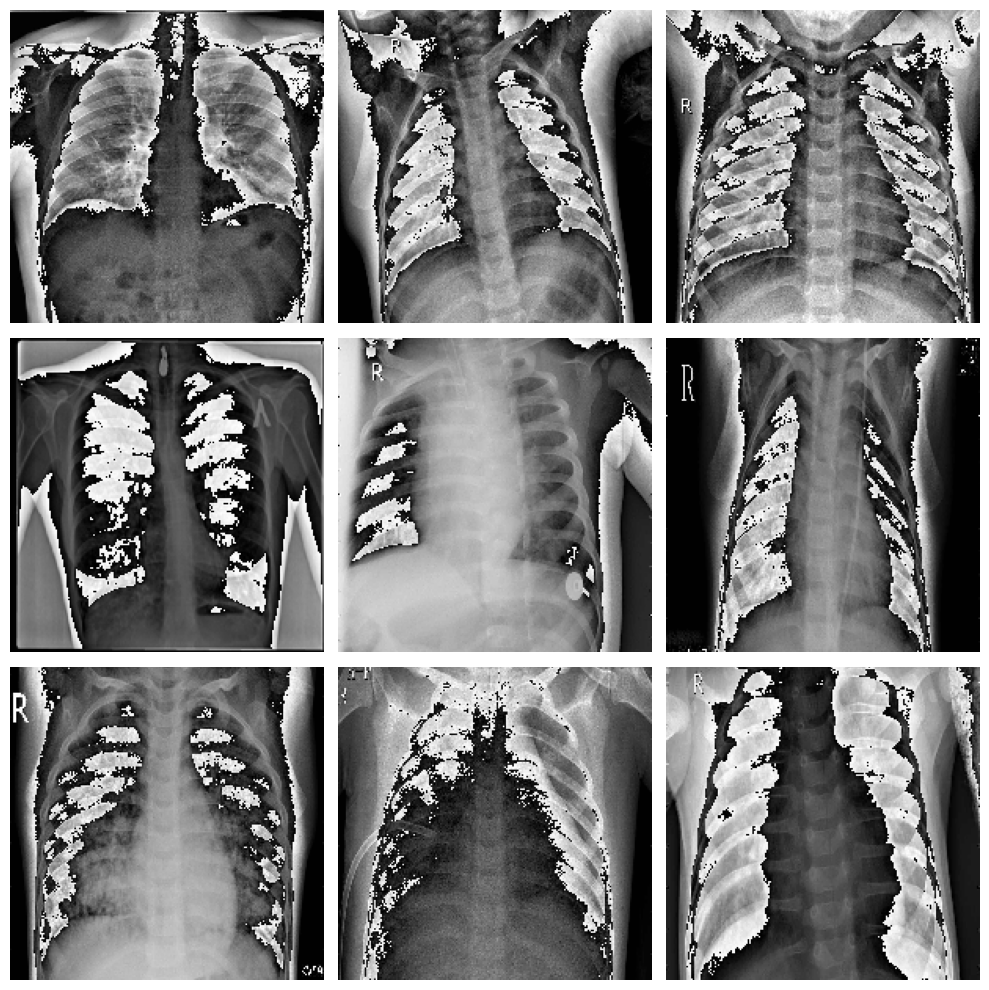

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    sample_img = next(train_data)[0][0] * 255
    plt.imshow(sample_img.astype('uint8'))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

In [12]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Increase neurons for better learning
x = BatchNormalization()(x)          # Normalize for stable learning
x = Dropout(0.5)(x)                   # Add dropout to reduce overfitting
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output_layer = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output_layer)

In [13]:
for layer in base_model.layers:
    layer.trainable = False

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
callbacks = [
    ModelCheckpoint(filepath='best_model_densenet.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

In [17]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=callbacks,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE
)

Epoch 1/50


I0000 00:00:1732210082.852382     122 service.cc:145] XLA service 0x7f2e400029a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732210082.852440     122 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732210082.852447     122 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/316 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.2031 - loss: 2.6709   

I0000 00:00:1732210098.438066     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/316 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7673 - loss: 0.7534
Epoch 1: val_loss improved from inf to 0.23663, saving model to best_model_densenet.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 162s 416ms/step - accuracy: 0.7678 - loss: 0.7519 - val_accuracy: 0.8333 - val_loss: 0.2366
Epoch 2/50
  1/316 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 1.0000 - loss: 0.0341
Epoch 2: val_loss improved from 0.23663 to 0.21406, saving model to best_model_densenet.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0341 - val_accuracy: 0.8333 - val_loss: 0.2141
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9061 - loss: 0.2672
Epoch 3: val_loss did not improve from 0.21406
316/316 ━━━━━━━━━━━━━━━━━━━━ 53s 164ms/step - accuracy: 0.9062 - loss: 0.2671 - val_accuracy: 0.8333 - val_loss: 0.3555
Epoch 4/50
  1/316 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8125 - loss: 0.2929
Epoch 4: val_loss did not improve from 0.21406
316/316 ━━━━━━━━━━━━━━━

In [18]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

test_loss, test_acc = model.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8333 - loss: 0.7999
Validation Loss: 0.7998618483543396, Validation Accuracy: 0.8333333134651184
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 460ms/step - accuracy: 0.7561 - loss: 0.7942
Test Loss: 0.617139458656311, Test Accuracy: 0.8145266175270081


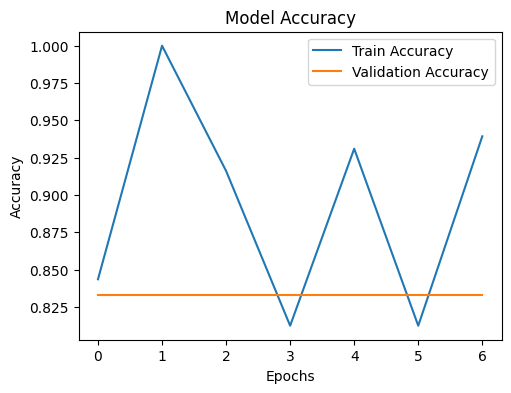

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

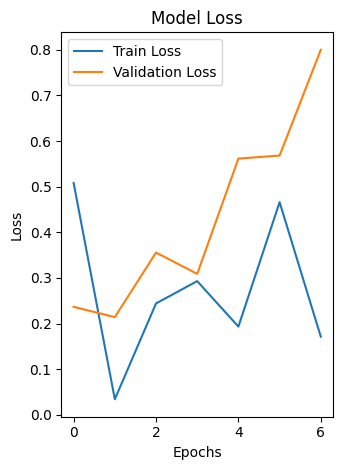

In [20]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
y_pred = model.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred,axis=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 302ms/step


In [22]:
print("Classification Report:")
print(classification_report(test_data.classes, y_pred_classes, target_names=class_labels))

Classification Report:
               precision    recall  f1-score   support

      COVID19       0.99      0.92      0.95       106
       NORMAL       0.95      0.45      0.61       234
    PNEUMONIA       0.75      0.99      0.85       390
TURBERCULOSIS       0.87      0.98      0.92        41

     accuracy                           0.81       771
    macro avg       0.89      0.83      0.83       771
 weighted avg       0.85      0.81      0.80       771



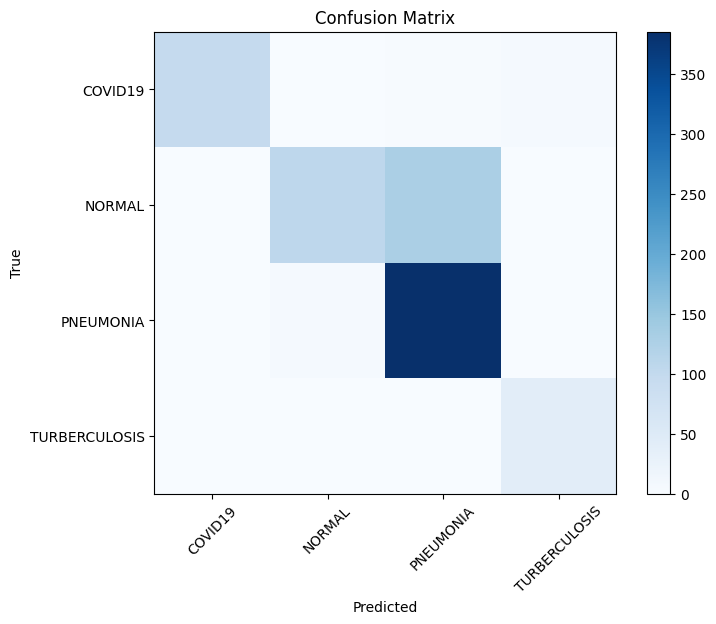

In [23]:
conf_matrix = confusion_matrix(test_data.classes, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Model saved to disk.


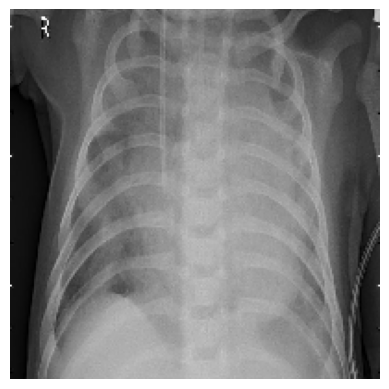

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted Class: PNEUMONIA


In [25]:
model.save("lungs_classification_model_densenet.h5")
print("Model saved to disk.")

# Prediction function
def predict_image(model_path, image_path, class_labels):
    # Load the pre-trained model
    model = load_model("lungs_classification_model_densenet.h5")

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Display the image
    plt.imshow(np.array(img).astype('uint8'))
    plt.axis('off')
    plt.show()

    # Predict the class
    prediction = model.predict(img_array.reshape(1, 200, 200, 3))
    class_index = np.argmax(prediction)
    print(f"Predicted Class: {class_labels[class_index]}")

# Test the prediction function
predict_image("lungs_classification_model_densenet.h5", "/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/PNEUMONIA/person100_bacteria_480.jpeg", class_labels)